In [1]:
import torch
from torch import nn
class embedding(nn.Module):
    def __init__(self,patch_size,num_patches,num_dims):
        super().__init__()
        self.conv=nn.Conv2d(1,num_dims,patch_size,patch_size,0)
    def forward(self,x):
        return self.conv(x).flatten(-2).permute(0,2,1)
        # return self.conv(x).flatten(-2)# batch no of keys and no of dims

class Attention(nn.Module):
    def __init__(self, dim, n_heads, dropout):
        super().__init__()
        self.n_heads = n_heads
        self.att = torch.nn.MultiheadAttention(embed_dim=dim,
                                               num_heads=n_heads,
                                               dropout=dropout)
        self.q = torch.nn.Linear(dim, dim)
        self.k = torch.nn.Linear(dim, dim)
        self.v = torch.nn.Linear(dim, dim)

    def forward(self, x):
        # x=x.permute(1,0,2)
        q = self.q(x)
        k = self.k(x)
        v = self.v(x)
        attn_output, attn_output_weights = self.att(q,k,v)
        return attn_output

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.feed=nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout))
    def forward(self,x):
        return self.feed(x)

class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.feed=nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout))
    def forward(self,x):
        return self.feed(x)

In [2]:
from einops import repeat
class ViT(nn.Module):
    def __init__(self, ch=1, img_size=28, patch_size=4, emb_dim=16,
                n_layers=2, out_dim=10, dropout=0.1, heads=4):
        super(ViT, self).__init__()

        self.channels = ch
        self.height = img_size
        self.width = img_size
        self.patch_size = patch_size
        self.n_layers = n_layers

        self.patch_embedding = embedding(patch_size,img_size//patch_size,
                                              emb_dim)
        num_patches = (img_size // patch_size) ** 2
        self.pos_embedding = nn.Parameter(
            torch.randn(1, num_patches + 1, emb_dim))
        self.cls_token = nn.Parameter(torch.rand(1, 1, emb_dim))

        self.layers = nn.ModuleList([])
        for _ in range(n_layers):
            transformer_block = nn.Sequential(
                ResidualAdd(PreNorm(emb_dim, Attention(emb_dim, n_heads = heads, dropout = dropout))),
                ResidualAdd(PreNorm(emb_dim, FeedForward(emb_dim, emb_dim, dropout = dropout))))
            self.layers.append(transformer_block)

        self.head = nn.Sequential(nn.LayerNorm(emb_dim), nn.Linear(emb_dim, out_dim))


    def forward(self, img):
        x = self.patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat([cls_tokens, x], dim=1)
        x += self.pos_embedding[:, :(n + 1)]

        for i in range(self.n_layers):
            x = self.layers[i](x)

        return self.head(x[:, 0, :])


model = ViT()
print(model)
model(torch.ones((32, 1, 28,28))).shape

ViT(
  (patch_embedding): embedding(
    (conv): Conv2d(1, 16, kernel_size=(4, 4), stride=(4, 4))
  )
  (layers): ModuleList(
    (0-1): 2 x Sequential(
      (0): ResidualAdd(
        (fn): PreNorm(
          (norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (att): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
            )
            (q): Linear(in_features=16, out_features=16, bias=True)
            (k): Linear(in_features=16, out_features=16, bias=True)
            (v): Linear(in_features=16, out_features=16, bias=True)
          )
        )
      )
      (1): ResidualAdd(
        (fn): PreNorm(
          (norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (feed): Sequential(
              (0): Linear(in_features=16, out_features=16, bias=True)
              (1): GELU(approximate='none')
              (2): D

torch.Size([32, 10])

In [3]:

ff = FeedForward(dim=128, hidden_dim=256)
ff(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 128])

In [4]:
inp=torch.rand([1,  49,16])
model=Attention(16,16,0.01)

output=model(inp)
output.shape

torch.Size([1, 49, 16])

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)


class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc = nn.Linear(16 * 14 * 14, 10) 

    def forward(self, x):
        x = self.pool(torch.relu(self.conv(x)))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = SimpleCNN()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def one_hot(labels, num_classes=10):
    return torch.nn.functional.one_hot(labels, num_classes).float()


def calculate_accuracy(outputs, labels):
    
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    return correct / labels.size(0)

num_epochs = 5
from tqdm import tqdm
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
    
    # Evaluate on the test set
    model.eval()
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            total_correct += (torch.max(outputs, 1)[1] == labels).sum().item()
            total_samples += labels.size(0)
    accuracy_val = total_correct / total_samples
    print(f"Test Accuracy: {accuracy_val:.4f}")


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.46MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.52MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.24MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 938/938 [00:18<00:00, 51.53it/s]


Epoch [1/5], Loss: 0.2112
Test Accuracy: 0.9679


100%|██████████| 938/938 [00:17<00:00, 53.30it/s]


Epoch [2/5], Loss: 0.0852
Test Accuracy: 0.9766


100%|██████████| 938/938 [00:17<00:00, 53.47it/s]


Epoch [3/5], Loss: 0.0658
Test Accuracy: 0.9818


100%|██████████| 938/938 [00:17<00:00, 53.09it/s]


Epoch [4/5], Loss: 0.0534
Test Accuracy: 0.9787


100%|██████████| 938/938 [00:17<00:00, 52.56it/s]


Epoch [5/5], Loss: 0.0463
Test Accuracy: 0.9802


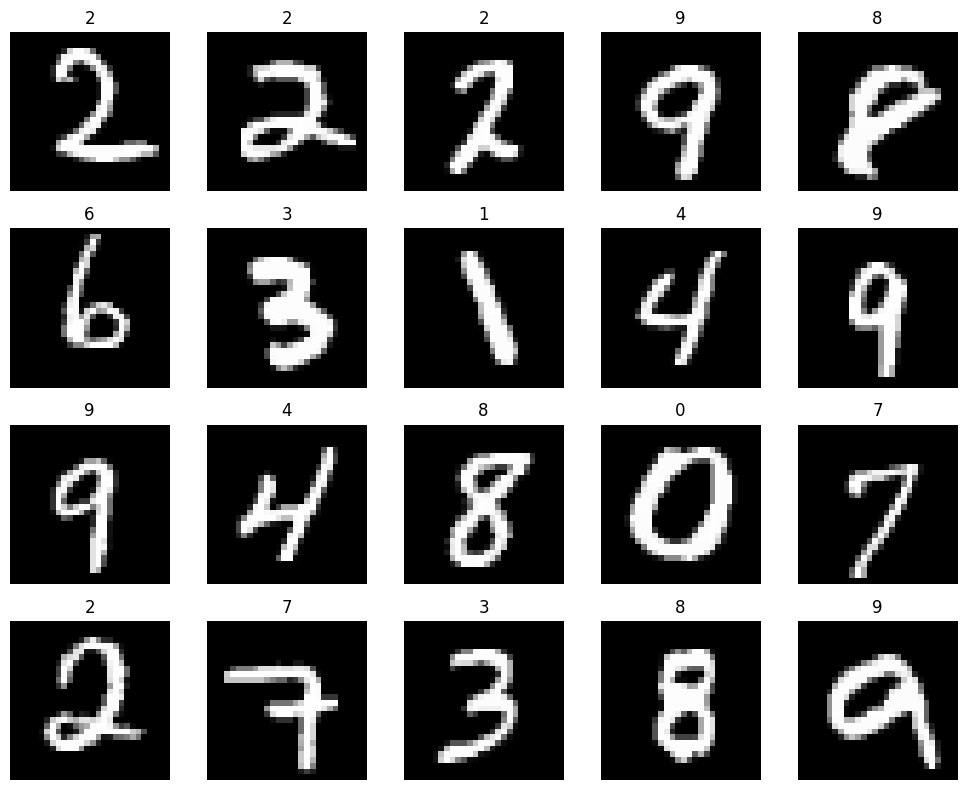

In [6]:
import matplotlib.pyplot as plt
import random

num_images = 20
indices = random.sample(range(len(test_dataset)), num_images)

fig, axes = plt.subplots(4, 5, figsize=(10, 8))
axes = axes.flatten()

for idx, ax in zip(indices, axes):
    img, label = test_dataset[idx]
    img = img.squeeze(0)
    
    ax.imshow(img, cmap='gray')
    ax.set_title(str(label))
    ax.axis('off')

plt.tight_layout()
plt.show()
